# Modulação DDO-CE-OFDM

Este código apresenta uma implementação de um sistema de comunicação óptica de detecção direta com modulação OFDM e envelope constante (DDO-CE-OFDM). 

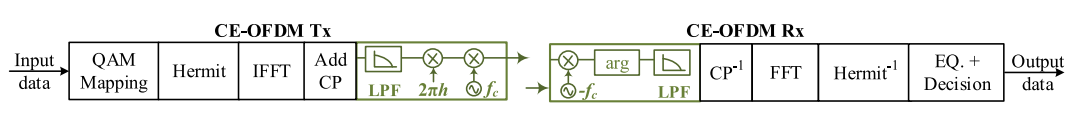

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc
from optic.core        import parameters
from optic.models      import ssfm

from utils.ce_ofdm     import Tx, Rx

pi = np.pi

In [3]:
font = {'family':'serif', 'weight':'normal', 'size':16}
plt.rc('font', **font)
plt.rc('lines',lw = 2)

## 1 - Transmissão

In [4]:
paramTx = parameters()

# Parâmetros da transmissão
paramTx.SpS = 32           # Amostras por símbolo
paramTx.Rs  = 1.5e9        # Taxa de símbolo
paramTx.Ts  = 1/paramTx.Rs # Tempo de símblo
paramTx.Fa  = 1/(paramTx.Ts/paramTx.SpS) # Frequência de amostragem
paramTx.Ta  = 1/paramTx.Fa # Período de amostragem

# Parâmetros do esquema OFDM
paramTx.M = 4    # Número de símbolos da constelação QAM
paramTx.N = 512  # Dobro do número de sub-portadoras
paramTx.G = 4    # Tamanho do prefixo cíclico
paramTx.K = 8   # Número de portadoras piloto por bloco OFDM

# Parâmetros da portadora elétrica
paramTx.H  = 0.35/(2*pi) # Índice de modulação
paramTx.fc = 1e9         # Frequência da portadora [Hz]
paramTx.A  = 1           # Amplitude da portadora

# Parâmetros do MZM e potência de entrada
paramTx.Vπ    = 3
paramTx.Vb    = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 2

In [5]:
sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)

## 2 - Canal óptico

In [6]:
paramCh = parameters()

# Parâmetros da fibra
paramCh.Ltotal = 500        # Comprimento total do link [km]
paramCh.Lspan  = 100        # Comprimento de um span de fibra [km]
paramCh.hz     = 0.5        # Comprimento do passo para o método SSF [km]
paramCh.alpha  = 0.2        # Atenuação da fibra [dB/km]
paramCh.D      = 16         # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma  = 1.3        # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp    = 'edfa'     # Tipo de amplificador
paramCh.NF     = 4.5        # Figura de ruído do amplificador [dB]
paramCh.Fc     = paramTx.Fc # Frequência da portadora óptica [Hz]

In [ ]:
sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)

## 3 - Recepção

In [7]:
paramRx = parameters()

# Parâmetros do receptor
paramRx.Tc = 25    # Temperatura [°C]
paramRx.Rd = 0.85  # Responsividade
paramRx.Id = 5e-9  # Corrente de escuro [A]
paramRx.RL = 50    # Resistência [Ω]
paramRx.B  = 10e9  # Largura de banda [Hz]

paramRx.Fa  = paramTx.Fa   # Frequência de amostragem
paramRx.SpS = paramTx.SpS  # Amostras por símbolo
paramRx.H   = paramTx.H    # Índice de modulação
paramRx.fc  = paramTx.fc   # Frequência da portadora elétrica

paramRx.N = paramTx.N
paramRx.G = paramTx.G
paramRx.K = paramTx.K

In [479]:
symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)

## 4 - Desempenho do sistema

### 4.1 - Com equalização

In [480]:
symbRx[0::int(paramTx.N/2)] = 'nan'
symbTx[0::int(paramTx.N/2)] = 'nan'

symbTx = symbTx[~np.isnan(symbTx)]
symbRx = symbRx[~np.isnan(symbRx)]

# Cálculo da BER
fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')

(array([0.]), array([0.]), array([19.61226609]))

(-1.5, 1.5)

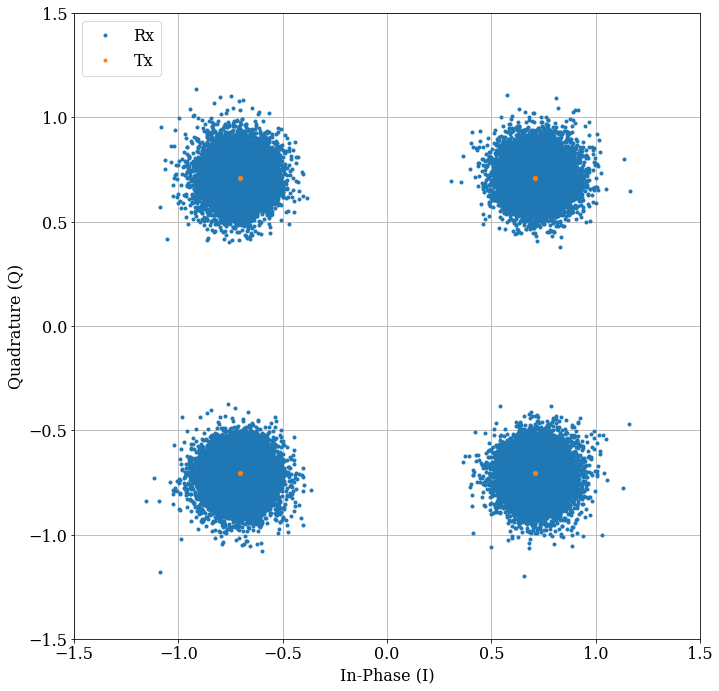

In [481]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(10, 10))
plt.plot(symbRx.real, symbRx.imag, '.', label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.grid()

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

### 4.2 - Sem equalização

In [482]:
symbRx_neq[0::int(paramTx.N/2)] = 'nan'

symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]

# Cálculo da BER
fastBERcalc(symbRx_neq, symbTx, paramTx.M, 'qam')

(array([0.]), array([0.]), array([19.91876409]))

(-1.5, 1.5)

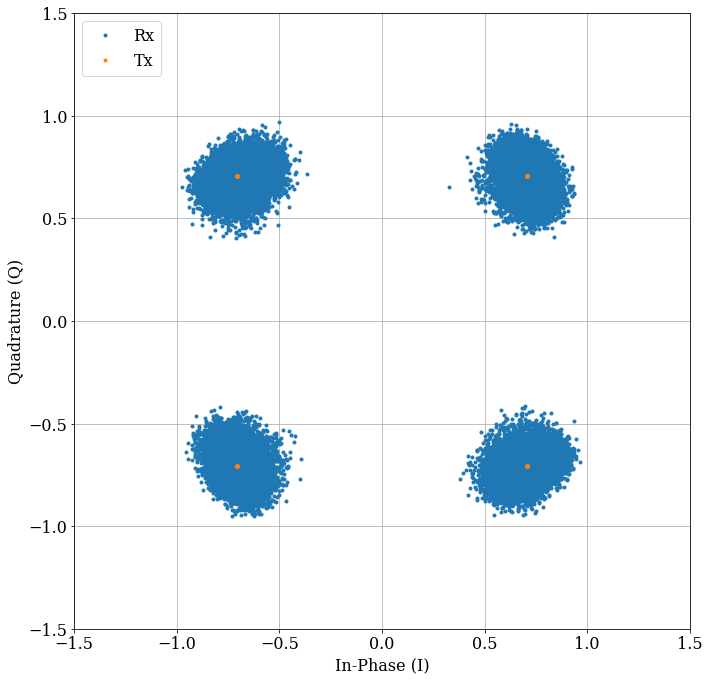

In [483]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(10, 10))
plt.plot(symbRx_neq.real, symbRx_neq.imag, '.', label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.grid()

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

## Desempenho 4-QAM

## 1 - Escolha dos parâmetros ótimos de transmissão

### 1.1 - $V_{bias}$

In [26]:
Ltotal = np.arange(600, 1200, 100)
ratio  = np.arange(0, 1.1, 0.1)
BER = np.zeros((len(Ltotal), len(ratio)))

for i, L in enumerate(Ltotal):
    paramCh.Ltotal = L
    for j, R in enumerate(ratio):
        paramTx.Vb = -R*paramTx.Vπ
        sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)
        
        symbRx[0::int(paramTx.N/2)] = 'nan'
        symbTx[0::int(paramTx.N/2)] = 'nan'

        symbTx = symbTx[~np.isnan(symbTx)]
        symbRx = symbRx[~np.isnan(symbRx)]

        # Cálculo da BER
        BER[i][j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


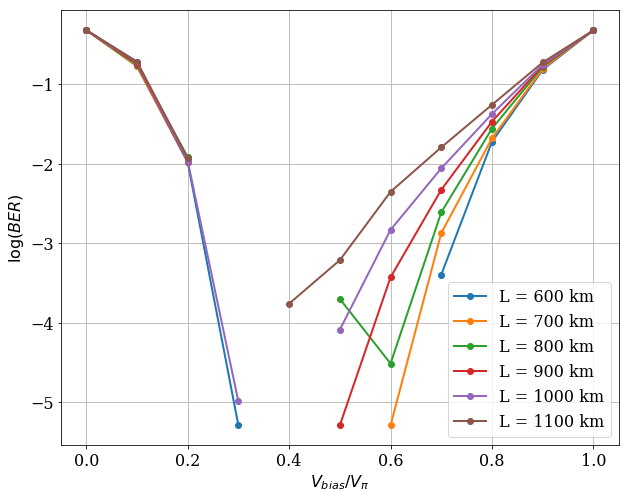

In [32]:
plt.figure(figsize = (10, 8 ))

for i in range(len(BER)):
    plt.plot(ratio, np.log10(BER[i,:]), '-o', label = f"L = {Ltotal[i]} km")

plt.ylabel(r"$\log(BER)$")
plt.xlabel(r"$V_{bias}/V_{\pi}$")
plt.legend()
plt.grid()

### 1.2 - Índice de modulação $h$

In [9]:
Ltotal = np.arange(600, 1200, 100)
H  = np.arange(0.2, 0.55, 0.05) / (2*pi) 
BER = np.zeros((len(Ltotal), len(H)))
paramTx.Vb = -0.5*paramTx.Vπ

for i, L in enumerate(Ltotal):
    paramCh.Ltotal = L
    for j in range(len(H)):
        paramTx.H = H[j]
        paramRx.H = H[j]
        sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)
        
        symbRx[0::int(paramTx.N/2)] = 'nan'
        symbTx[0::int(paramTx.N/2)] = 'nan'

        symbTx = symbTx[~np.isnan(symbTx)]
        symbRx = symbRx[~np.isnan(symbRx)]

        # Cálculo da BER
        BER[i][j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


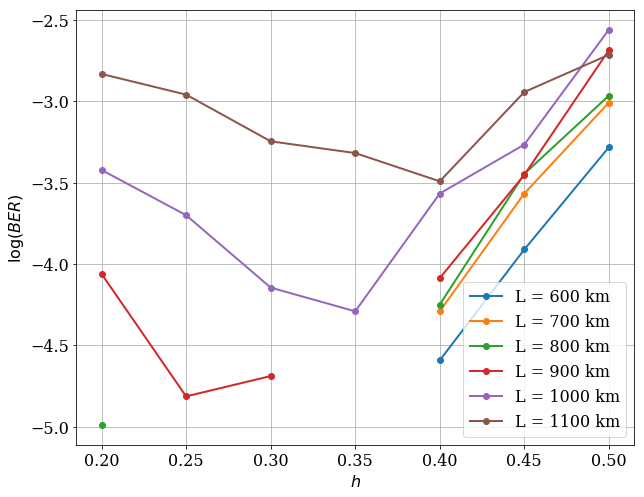

In [12]:
plt.figure(figsize = (10, 8 ))

for i in range(len(BER)):
    plt.plot(H*(2*pi), np.log10(BER[i,:]), '-o', label = f"L = {Ltotal[i]} km")

plt.ylabel(r"$\log(BER)$")
plt.xlabel(r"$h$")
plt.legend()
plt.grid()

### 5.1 - Variando a potência de entrada

In [19]:
# Pi = 2 dBm
Ltotal = np.arange(600, 1300, 100)
H  = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.4, 0.4])/(2*pi)
BER = np.zeros(len(Ltotal))
paramTx.Vb = -0.5*paramTx.Vπ

for j, L in enumerate(Ltotal):
    paramCh.Ltotal = L
    paramTx.H = H[j]
    paramRx.H = H[j]
    sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)
    
    symbRx[0::int(paramTx.N/2)] = 'nan'
    symbTx[0::int(paramTx.N/2)] = 'nan'

    symbTx = symbTx[~np.isnan(symbTx)]
    symbRx = symbRx[~np.isnan(symbRx)]
    
    # Cálculo da BER
    BER[j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


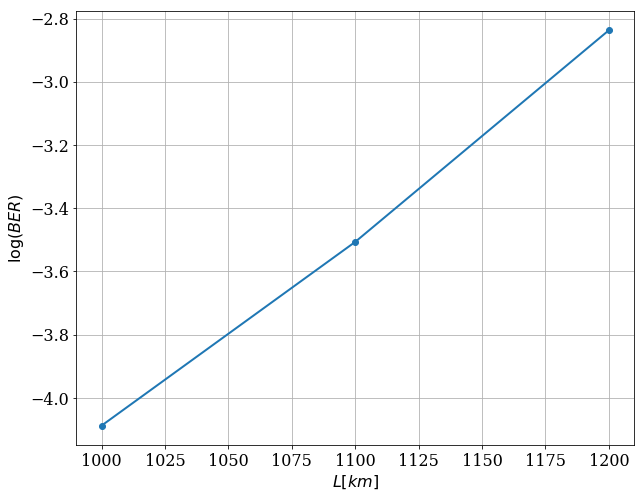

In [20]:
plt.figure(figsize = (10, 8))
plt.plot(Ltotal, np.log10(BER), '-o')

plt.ylabel(r"$\log(BER)$")
plt.xlabel(r"$L [km]$")
plt.grid()

In [21]:
BER

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.16993464e-05, 3.11478758e-04, 1.45526961e-03])

In [22]:
# Pi = 4 dBm
paramTx.Pi_dBm = 4 
Ltotal = np.arange(600, 1300, 100)
H  = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.4, 0.4])/(2*pi)
BER = np.zeros(len(Ltotal))
paramTx.Vb = -0.5*paramTx.Vπ

for j, L in enumerate(Ltotal):
    paramCh.Ltotal = L
    paramTx.H = H[j]
    paramRx.H = H[j]
    sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)
    
    symbRx[0::int(paramTx.N/2)] = 'nan'
    symbTx[0::int(paramTx.N/2)] = 'nan'

    symbTx = symbTx[~np.isnan(symbTx)]
    symbRx = symbRx[~np.isnan(symbRx)]
    
    # Cálculo da BER
    BER[j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


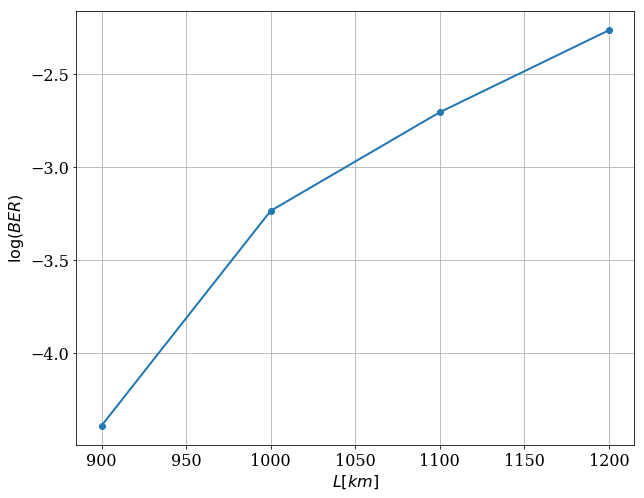

In [23]:
plt.figure(figsize = (10, 8))
plt.plot(Ltotal, np.log10(BER), '-o')

plt.ylabel(r"$\log(BER)$")
plt.xlabel(r"$L [km]$")
plt.grid()

In [24]:
# Pi = 10 dBm
paramTx.Pi_dBm = 10
Ltotal = np.arange(600, 1300, 100)
H  = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.4, 0.4])/(2*pi)
BER = np.zeros(len(Ltotal))
paramTx.Vb = -0.5*paramTx.Vπ

for j, L in enumerate(Ltotal):
    paramCh.Ltotal = L
    paramTx.H = H[j]
    paramRx.H = H[j]
    sigTxo, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    symbRx, symbRx_neq, H_abs, H_pha = Rx(sigRxo, pilot, pulse, t, paramRx)
    
    symbRx[0::int(paramTx.N/2)] = 'nan'
    symbTx[0::int(paramTx.N/2)] = 'nan'

    symbTx = symbTx[~np.isnan(symbTx)]
    symbRx = symbRx[~np.isnan(symbRx)]
    
    # Cálculo da BER
    BER[j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

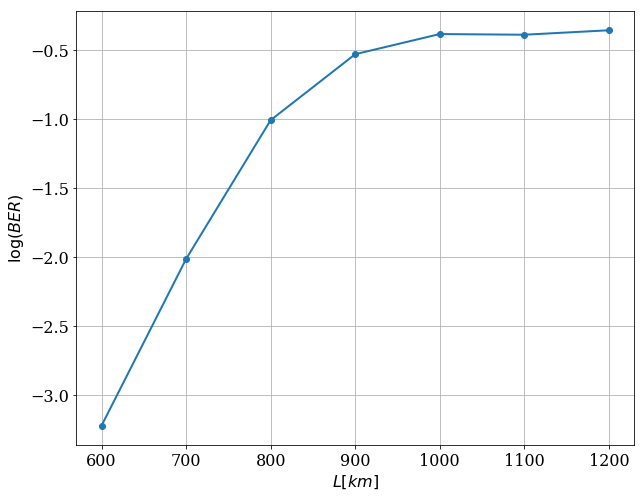

In [25]:
plt.figure(figsize = (10, 8))
plt.plot(Ltotal, np.log10(BER), '-o')

plt.ylabel(r"$\log(BER)$")
plt.xlabel(r"$L [km]$")
plt.grid()